100%|██████████| 18.2M/18.2M [00:14<00:00, 1.29MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 181kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.16MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.77MB/s]



Training with batch size: 8
Batch Size [8], Epoch [1/10], Loss: 0.2148, Accuracy: 93.30%, Test Accuracy: 91.33%
Batch Size [8], Epoch [2/10], Loss: 0.0842, Accuracy: 97.43%, Test Accuracy: 93.63%
Batch Size [8], Epoch [3/10], Loss: 0.0611, Accuracy: 98.14%, Test Accuracy: 94.73%
Batch Size [8], Epoch [4/10], Loss: 0.0477, Accuracy: 98.57%, Test Accuracy: 95.32%
Batch Size [8], Epoch [5/10], Loss: 0.0379, Accuracy: 98.81%, Test Accuracy: 95.07%
Batch Size [8], Epoch [6/10], Loss: 0.0334, Accuracy: 98.94%, Test Accuracy: 94.64%
Batch Size [8], Epoch [7/10], Loss: 0.0290, Accuracy: 99.09%, Test Accuracy: 94.92%
Batch Size [8], Epoch [8/10], Loss: 0.0262, Accuracy: 99.20%, Test Accuracy: 95.36%
Batch Size [8], Epoch [9/10], Loss: 0.0243, Accuracy: 99.24%, Test Accuracy: 95.53%
Batch Size [8], Epoch [10/10], Loss: 0.0242, Accuracy: 99.23%, Test Accuracy: 95.64%

Training with batch size: 16
Batch Size [16], Epoch [1/10], Loss: 0.2250, Accuracy: 93.08%, Test Accuracy: 91.82%
Batch Size [16]

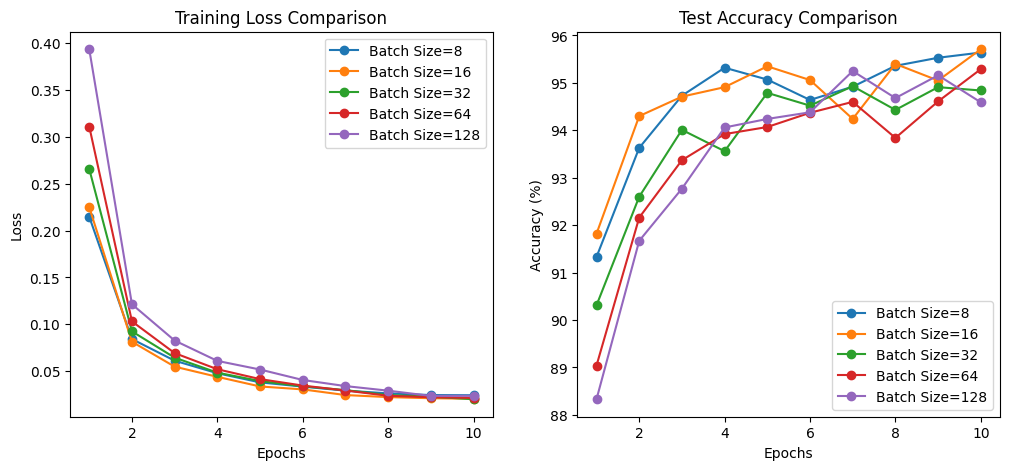

In [ ]:
# Set the save path
save_dir = "/content/drive/MyDrive/Colab Notebooks/DL-小组作业"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Data augmentation: random rotation ±10 degrees
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training and test datasets
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function (with logging to CSV)
def train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []

    # Open CSV file for logging
    filename = f"{save_dir}/batch_size_{batch_size}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_accuracy", "test_accuracy"])

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # Evaluate the model on the test set
            test_loss, test_acc = test_model(model, test_loader)
            print(f"Batch Size [{batch_size}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

            # Write to CSV
            writer.writerow([epoch+1, epoch_loss, epoch_acc, test_acc])

    return train_losses, train_accuracies

# Testing function
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct / total
    return avg_test_loss, avg_test_acc

# Performance visualization
def plot_performance_comparison(batch_sizes, num_epochs):
    plt.figure(figsize=(12, 5))

    # Plot training losses
    plt.subplot(1, 2, 1)
    for bs in batch_sizes:
        filename = f"{save_dir}/batch_size_{bs}.csv"
        epochs, train_losses, _, _ = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
        plt.plot(epochs, train_losses, label=f"Batch Size={bs}", marker='o')
    plt.title("Training Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot test accuracies
    plt.subplot(1, 2, 2)
    for bs in batch_sizes:
        filename = f"{save_dir}/batch_size_{bs}.csv"
        epochs, _, _, test_accuracies = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
        plt.plot(epochs, test_accuracies, label=f"Batch Size={bs}", marker='o')
    plt.title("Test Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# Main loop: different batch sizes
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001  # Fixed learning rate
batch_sizes = [8, 16, 32, 64, 128]
num_epochs = 10

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = SimpleCNN().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train and log results
    train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, bs)

# Visualize performance comparison
plot_performance_comparison(batch_sizes, num_epochs)

100%|██████████| 18.2M/18.2M [00:14<00:00, 1.24MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 3.04M/3.04M [00:03<00:00, 883kB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 9.54MB/s]



Training with batch size: 16
Batch Size [16], Epoch [1/10], Loss: 0.2474, Accuracy: 92.34%, Test Accuracy: 89.76%
Batch Size [16], Epoch [2/10], Loss: 0.0917, Accuracy: 97.22%, Test Accuracy: 93.13%
Batch Size [16], Epoch [3/10], Loss: 0.0637, Accuracy: 98.01%, Test Accuracy: 93.76%
Batch Size [16], Epoch [4/10], Loss: 0.0486, Accuracy: 98.48%, Test Accuracy: 94.58%
Batch Size [16], Epoch [5/10], Loss: 0.0410, Accuracy: 98.71%, Test Accuracy: 94.89%
Batch Size [16], Epoch [6/10], Loss: 0.0349, Accuracy: 98.89%, Test Accuracy: 94.68%
Batch Size [16], Epoch [7/10], Loss: 0.0301, Accuracy: 99.00%, Test Accuracy: 95.06%
Batch Size [16], Epoch [8/10], Loss: 0.0285, Accuracy: 99.10%, Test Accuracy: 94.44%
Batch Size [16], Epoch [9/10], Loss: 0.0252, Accuracy: 99.23%, Test Accuracy: 95.43%
Batch Size [16], Epoch [10/10], Loss: 0.0215, Accuracy: 99.29%, Test Accuracy: 94.29%


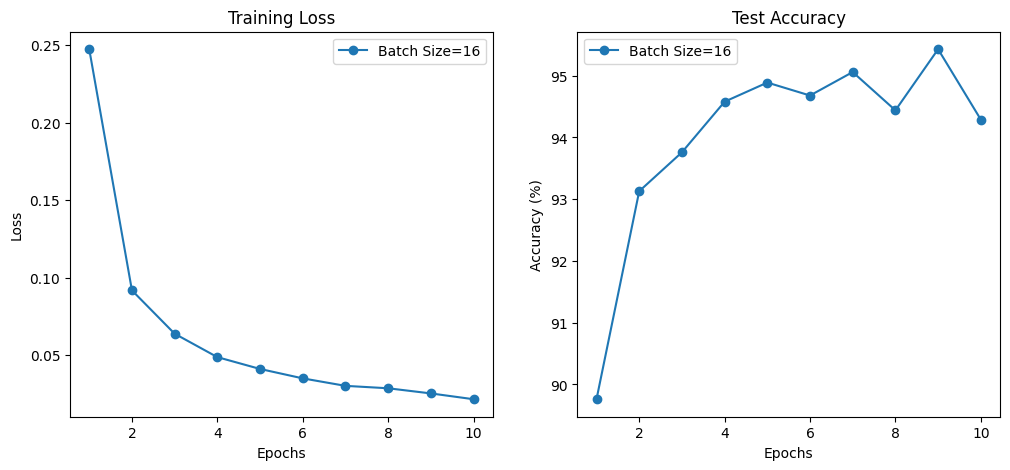

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import csv
import os
from google.colab import drive  # 用于挂载 Google Drive

# 设置保存路径
save_dir = "/content/drive/MyDrive/Colab Notebooks/DL-小组作业"
os.makedirs(save_dir, exist_ok=True)  # 如果目录不存在，则创建

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (normalization + data augmentation)
transform = transforms.Compose([
    transforms.RandomRotation(10),  # 数据增强：随机旋转 ±10 度
    transforms.ToTensor(),          # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
])

# 加载训练和测试数据集
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 训练函数（带日志记录到 CSV）
def train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []

    # 打开 CSV 文件进行日志记录
    filename = f"{save_dir}/batch_size_{batch_size}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_accuracy", "test_accuracy"])

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # 在测试集上评估模型
            test_loss, test_acc = test_model(model, test_loader)
            print(f"Batch Size [{batch_size}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

            # 写入 CSV
            writer.writerow([epoch+1, epoch_loss, epoch_acc, test_acc])

    return train_losses, train_accuracies

# 测试函数
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct / total
    return avg_test_loss, avg_test_acc

# 性能可视化
def plot_performance(batch_size, num_epochs):
    plt.figure(figsize=(12, 5))

    # 绘制训练损失
    plt.subplot(1, 2, 1)
    filename = f"{save_dir}/batch_size_{batch_size}.csv"
    epochs, train_losses, _, _ = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
    plt.plot(epochs, train_losses, label=f"Batch Size={batch_size}", marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 绘制测试准确率
    plt.subplot(1, 2, 2)
    epochs, _, _, test_accuracies = zip(*[map(float, row) for row in csv.reader(open(filename))][1:])
    plt.plot(epochs, test_accuracies, label=f"Batch Size={batch_size}", marker='o')
    plt.title("Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

# 主循环：固定批量大小为 16
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001  # 固定学习率
batch_size = 16
num_epochs = 10

print(f"\nTraining with batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练并记录结果
train_model_with_logging(model, train_loader, criterion, optimizer, num_epochs, batch_size)

# 可视化性能
plot_performance(batch_size, num_epochs)